In [24]:
import matplotlib.pyplot as plt

import nengo
from nengo.processes import Piecewise

In [26]:
tau = 0.1  # Post-synaptic time constant for feedback
w_max = 10  # Maximum frequency in Hz is w_max/(2*pi)

model = nengo.Network(label="Controlled Oscillator")
with model:
    # The ensemble for the oscillator
    oscillator = nengo.Ensemble(500, dimensions=3, radius=1.7)

    # The feedback connection
    def feedback(x):
        x0, x1, w = x  # These are the three variables stored in the ensemble
        return x0 - w * w_max * tau * x1, x1 + w * w_max * tau * x0, 0

    nengo.Connection(oscillator, oscillator, function=feedback, synapse=tau)

    # The ensemble for controlling the speed of oscillation
    frequency = nengo.Ensemble(100, dimensions=1)

    nengo.Connection(frequency, oscillator[2])

In [27]:
with model:
    # We need a quick input at the beginning to start the oscillator
    initial = nengo.Node(Piecewise({0: [1, 0, 0], 0.15: [0, 0, 0]}))
    nengo.Connection(initial, oscillator)

    # Vary the speed over time
    input_frequency = nengo.Node(Piecewise({0: 1, 1: 0.5, 2: 0, 3: -0.5, 4: -1}))

    nengo.Connection(input_frequency, frequency)

In [28]:
with model:
    # Indicate which values to record (states and neural activity)
    # Low-pass filtered 3D state from the ensemble
    oscillator_probe = nengo.Probe(oscillator, synapse=0.06)
    # Record neuron output (proxy for spiking activity) for a raster-like plot
    spikes_probe = nengo.Probe(oscillator.neurons, 'output')
    # Record filtered neuron outputs per neuron so we can compute a population firing-rate
    pop_rate = nengo.Probe(oscillator.neurons, 'output', synapse=0.05)
    # Also record membrane voltages for a subset of neurons to inspect dynamics
    voltage_probe = nengo.Probe(oscillator.neurons, 'voltage')

In [29]:
with nengo.Simulator(model) as sim:
    sim.run(5)

Build finished in 0:00:01.                                                      

Simulation finished in 0:00:01.                                                 
Simulation finished in 0:00:01.                                                 


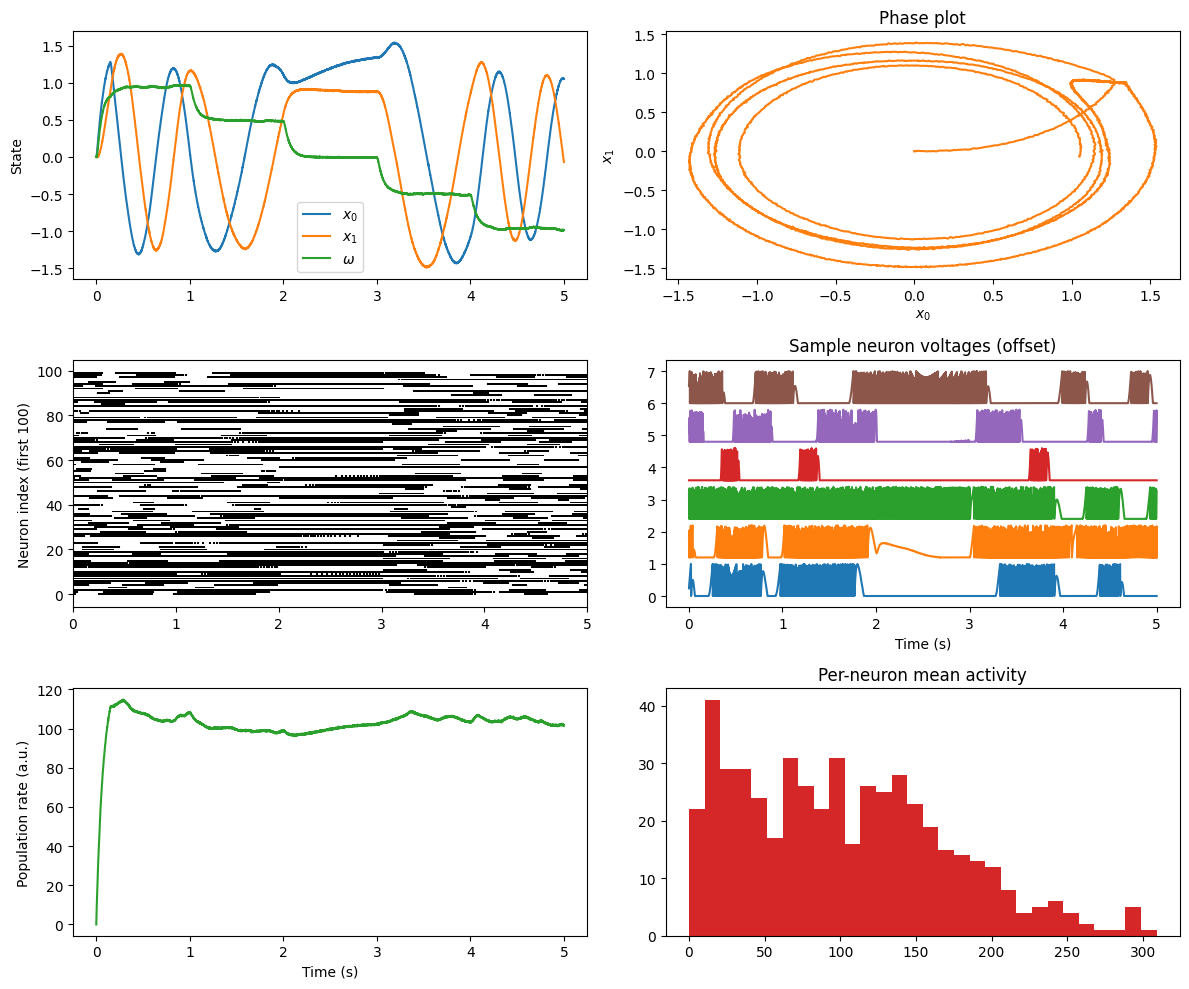

In [30]:
# Rich visualization: 3x2 grid
fig = plt.figure(figsize=(12, 10))
t = sim.trange()
# 1) State traces (x0, x1, omega)
ax1 = fig.add_subplot(3, 2, 1)
ax1.plot(t, sim.data[oscillator_probe])
ax1.set_ylabel("State")
ax1.legend(["$x_0$", "$x_1$", r"$\omega$"])

# 2) Phase plot x0 vs x1
ax2 = fig.add_subplot(3, 2, 2)
data = sim.data[oscillator_probe]
ax2.plot(data[:, 0], data[:, 1], color='C1')
ax2.set_xlabel('$x_0$')
ax2.set_ylabel('$x_1$')
ax2.set_title('Phase plot')

# 3) Spike raster for the first N neurons
ax3 = fig.add_subplot(3, 2, 3)
spikes = sim.data[spikes_probe]  # shape: (timesteps, n_neurons)
n_neurons = spikes.shape[1]
n_plot = min(100, n_neurons)
spike_times = [t[spikes[:, i] > 0] for i in range(n_plot)]
ax3.eventplot(spike_times, colors='black', linelengths=0.8)
ax3.set_ylabel('Neuron index (first %d)' % n_plot)
ax3.set_xlim(0, t[-1])

# 4) Sample neuron voltages (first 6 neurons), offset for clarity
ax4 = fig.add_subplot(3, 2, 4)
volt = sim.data[voltage_probe]  # (timesteps, n_neurons)
n_vplot = min(6, volt.shape[1])
offsets = np.arange(n_vplot) * 1.2
for i in range(n_vplot):
    ax4.plot(t, volt[:, i] + offsets[i], label=f'neuron {i}')
ax4.set_title('Sample neuron voltages (offset)')
ax4.set_xlabel('Time (s)')

# 5) Population firing-rate (average of filtered per-neuron outputs)
ax5 = fig.add_subplot(3, 2, 5)
population_rate = sim.data[pop_rate].mean(axis=1)
ax5.plot(t, population_rate, color='C2')
ax5.set_ylabel('Population rate (a.u.)')
ax5.set_xlabel("Time (s)")

# 6) Histogram of per-neuron mean activity (over the whole sim)
ax6 = fig.add_subplot(3, 2, 6)
mean_activity = sim.data[pop_rate].mean(axis=0)
ax6.hist(mean_activity, bins=30, color='C3')
ax6.set_title('Per-neuron mean activity')
plt.tight_layout()